# Preprocessing 
The processing steps follow the reference:

R. T. Schirrmeister, J. T. Springenberg, L. D. J. Fiederer, M. Glasstetter, K. Eggensperger, M. Tangermann, F. Hutter, W. Burgard, and T. Ball, “Deep learning with convolutional neural networks for eeg decoding and visualization,” Human Brain Mapping, vol. 38, no. 11, pp. 5391–5420, 2017. [Online]. Available:
http://dx.doi.org/10.1002/hbm.23730

# Data Loading

In [38]:
import mne
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib widget

In [39]:
ch_names = ['Fz', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 
            'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 
            'P1', 'Pz', 'P2', 'POz']

In [40]:
raw = mne.io.read_raw_gdf('./data/A01T.gdf',
                         eog=['EOG-left', 'EOG-central', 'EOG-right'], preload=True)
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])


Extracting EDF parameters from /home/seohyunseo/eeg_signal_processing_v2/data/A01T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/home/seohyunseo/.conda/envs/h_shs/lib/python3.11/contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Measurement date,"January 17, 2005 12:00:00 GMT"
Experimenter,Unknown
Participant,A01
Digitized points,Not available
Good channels,22 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [41]:
for i in range(len(ch_names)):
    raw.rename_channels({
        raw.info["ch_names"][i]: ch_names[i]
    })

In [42]:
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)


Measurement date,"January 17, 2005 12:00:00 GMT"
Experimenter,Unknown
Participant,A01
Digitized points,25 points
Good channels,22 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.50 Hz
Lowpass,100.00 Hz


In [7]:
# Check for NaN or inf values in your data
has_nan = np.isnan(raw.get_data()).any()
has_inf = np.isinf(raw.get_data()).any()

print(f'NaN: {has_nan}, Inf: {has_inf}')

NaN: False, Inf: False


# Raw Data visualization

In [8]:
# fig = raw.plot(scalings='auto', show=True)

In [9]:
# Plot the power spectral density 
# fig = raw.compute_psd(fmax=60, picks=[0]).plot(picks="data", exclude="bads", amplitude=False)

# Preprocessing

### Rereferencing

In [10]:
ref_ch = ['Cz'] # Change reference channel as you want
# Use the average of all channels as reference
ref_avr = "average"

# Conduct CAR (Common Average Reference)
raw_ref = raw.copy().set_eeg_reference(ref_channels=ref_avr)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


### Epoching

In [11]:
events = mne.events_from_annotations(raw_ref)
events[0].shape

Used Annotations descriptions: ['1023', '1072', '276', '277', '32766', '768', '769', '770', '771', '772']


(603, 3)

In [12]:
event_dict={
 'reject':1,
 'eye move':2,
 'eye open':3,
 'eye close':4,
 'new run':5,
 'new trial':6,
 'class 1':7,
 'class 2':8,
 'class 3':9,
 'class 4':10,
}

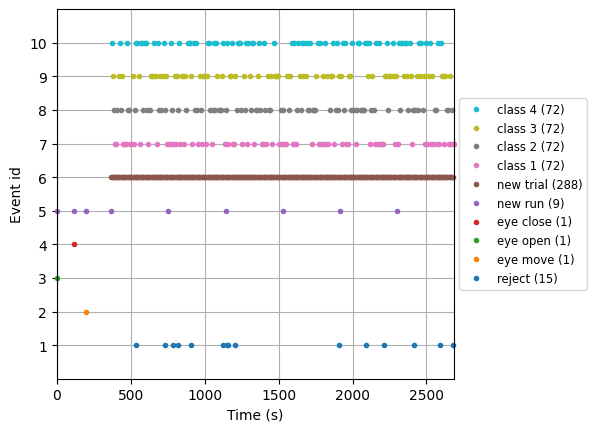

In [13]:
fig = mne.viz.plot_events(events[0], event_id=event_dict, sfreq=raw.info['sfreq'],
                          first_samp=raw_ref.first_samp)

In [14]:
# Extracts epochs of 3s time period from the datset into 288 events for all 4 classes 
tmin = -.5
tmax = 3.5
epochs = mne.Epochs(raw_ref, events[0], event_id=[7,8,9,10],tmin= tmin, tmax=tmax, preload=True, baseline=None)

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
0 bad epochs dropped


In [15]:
'''
epochs = mne.Epochs(raw_ref, events[0], event_id=[7,8,9,10],tmin= tmin, tmax=tmax, preload=True)
if baseline parameter isn't passed like above, then it is applied automatically 
'''
# Baseline correction
# baseline = (None, 0)
# epochs.apply_baseline(baseline)

"\nepochs = mne.Epochs(raw_ref, events[0], event_id=[7,8,9,10],tmin= tmin, tmax=tmax, preload=True)\nif baseline parameter isn't passed like above, then it is applied automatically \n"

Using matplotlib as 2D backend.


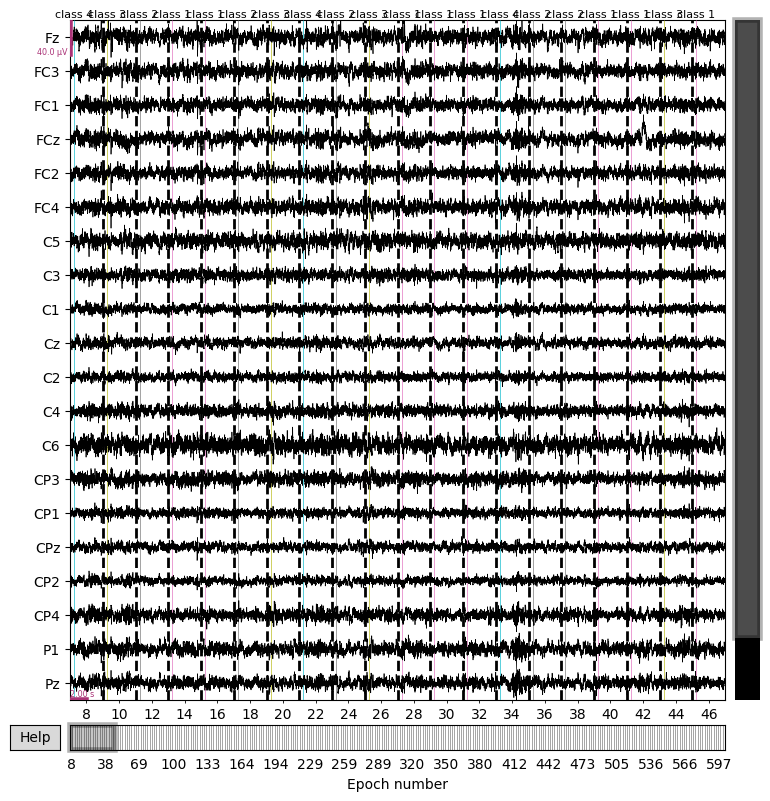

In [16]:
# Plot epoched data
fig = epochs.plot(events=events[0],
                  event_id=event_dict)

In [17]:
# Check for NaN or inf values in your data
has_nan = np.isnan(epochs.get_data(copy=False)).any()
has_inf = np.isinf(epochs.get_data(copy=False)).any()

print(f'NaN: {has_nan}, Inf: {has_inf}')

NaN: False, Inf: False


### Band-pass Filtering
0.05 - 50.0 Hz

In [18]:
# Filter the raw signal with a band pass filter in 0.5 - 50.0 Hz
l_freq = .05
h_freq = 70.0
iir_params = dict(order=8, ftype="butter")
epochs.filter(l_freq, h_freq, picks='eeg', method='iir', iir_params=iir_params)

Setting up band-pass filter from 0.05 - 70 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 32 (effective, after forward-backward)
- Cutoffs at 0.05, 70.00 Hz: -6.02, -6.02 dB



Number of events,288
Events,10: 727: 728: 729: 72
Time range,-0.500 – 3.500 s
Baseline,off


In [19]:
# Plot power spectral density filtered data
# epochs.compute_psd(fmax=70).plot()

### Removing artifact with ICA

In [20]:
# Create ICA object first
ica_obj = mne.preprocessing.ICA(
                    n_components=0.99,
                    method='infomax',
                    max_iter="auto",
                    random_state=1,
                    fit_params=dict(extended=True))

In [21]:
ica_obj.fit(epochs)

Fitting ICA to data using 22 channels (please be patient, this may take a while)


Selecting by explained variance: 14 components
Computing Extended Infomax ICA
Fitting ICA took 31.9s.


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on epochs (288288 samples)
ICA components,14
Available PCA components,22
Channel types,eeg
ICA components marked for exclusion,—


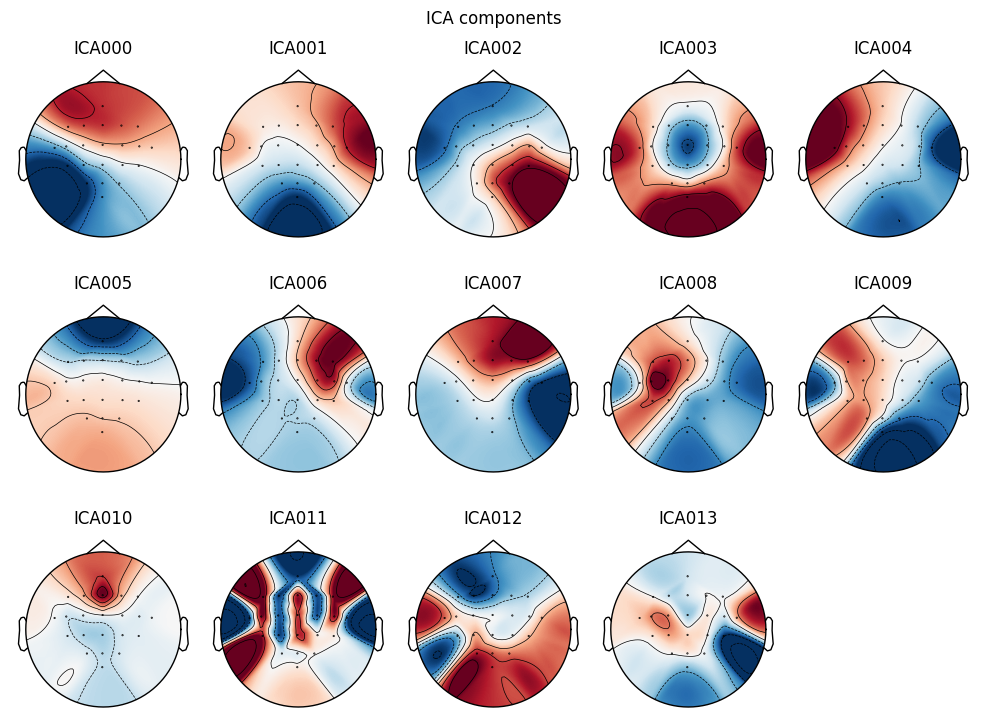

In [22]:
# Plot the ICA components
fig = ica_obj.plot_components()

    Using multitaper spectrum estimation with 7 DPSS windows


Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated


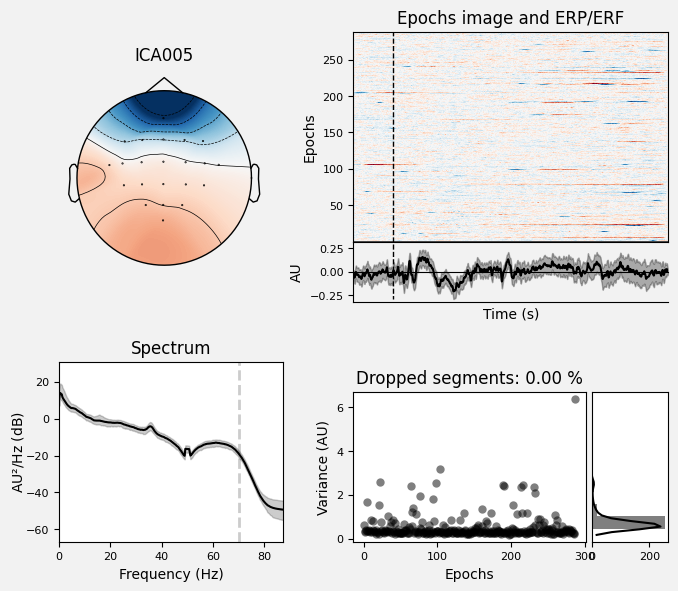

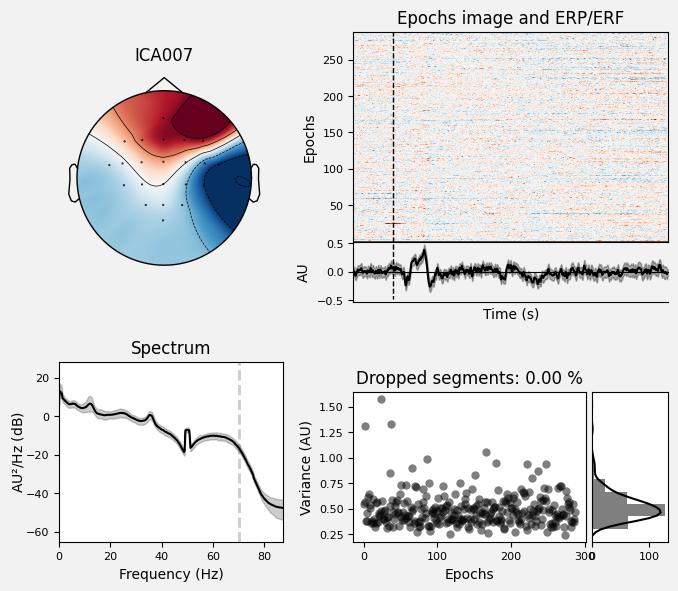

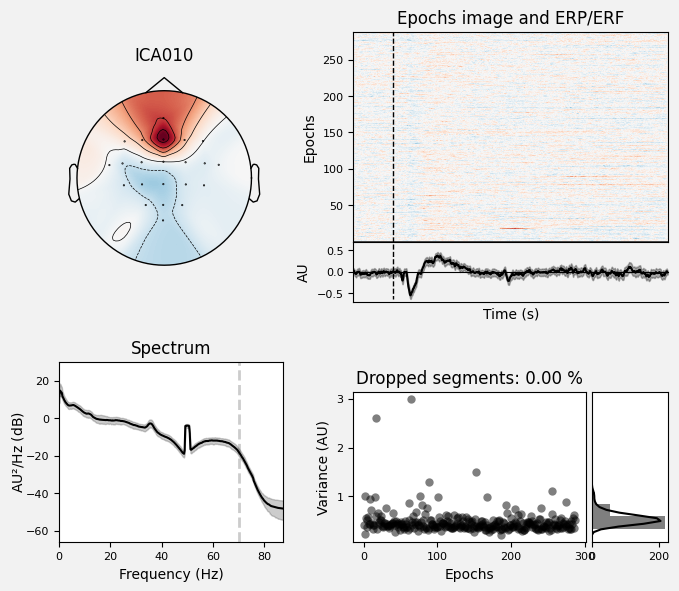

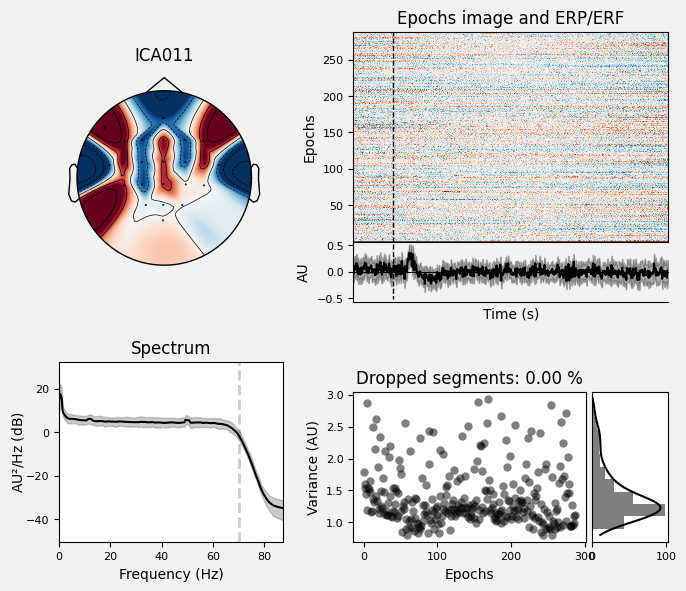

[<Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>,
 <Figure size 700x600 with 6 Axes>]

In [23]:
# plot diagnostics
ica_obj.plot_properties(epochs, picks=[5, 7, 10, 11])

Applying ICA to Raw instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


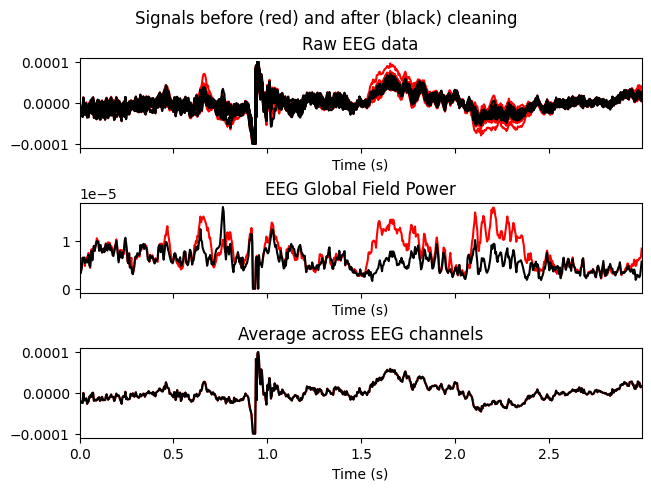

In [24]:
# blinks
fig = ica_obj.plot_overlay(raw, exclude=[5], picks="eeg")

In [25]:
# Drop bad ICA components
ica_obj.exclude = [5]
ica_obj.apply(epochs)

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 1 ICA component
    Projecting back using 22 PCA components


Number of events,288
Events,10: 727: 728: 729: 72
Time range,-0.500 – 3.500 s
Baseline,off


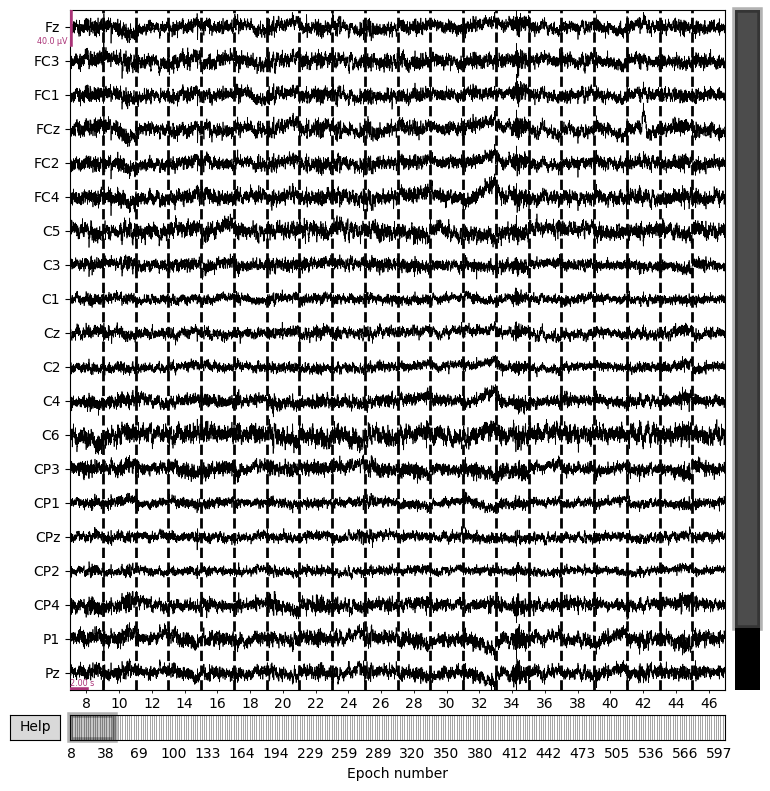

In [26]:
fig = epochs.plot()

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated


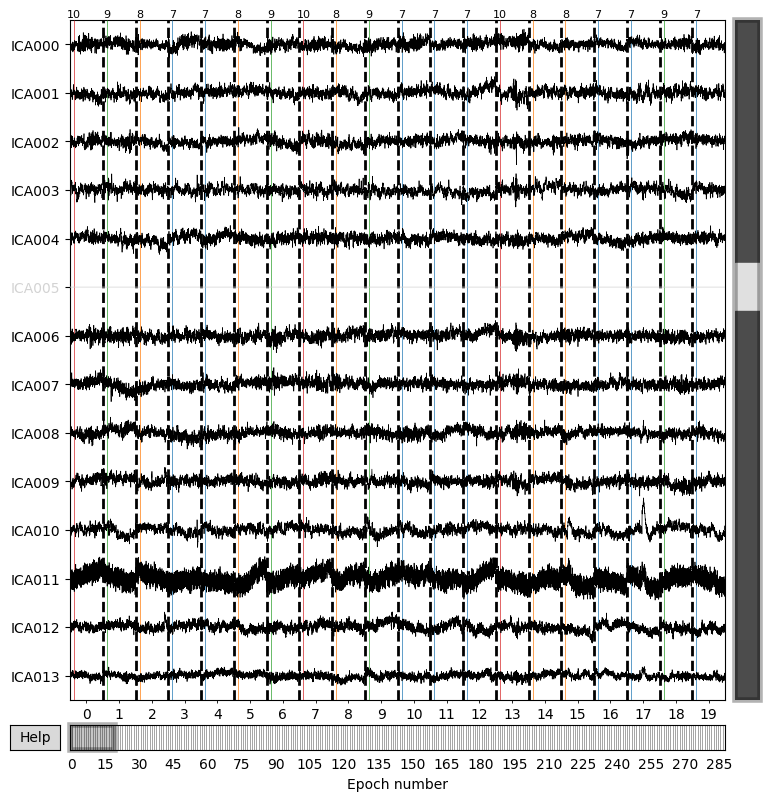

In [27]:
# Plot the ICA scources
fig = ica_obj.plot_sources(epochs)

In [28]:
# Drop bad epochs by observing
epochs.drop([45, 56])

Dropped 2 epochs: 45, 56


Number of events,286
Events,10: 727: 728: 709: 72
Time range,-0.500 – 3.500 s
Baseline,off


## Save Preprocessed Data

In [35]:
import pandas as pd

In [33]:
# Get data from epochs
epochs_data = epochs.get_data(copy=False)
labels = epochs.events[:, -1]
# Save data to CSV
np.save('./save/dataset_epochs/epochs_data.npy', epochs_data)

In [37]:
# Save labels to CSV
labels_df = pd.DataFrame({'labels': labels})
labels_df.to_csv('./save/dataset_epochs/labels.csv', index=False)